In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
!gdown https://drive.google.com/uc?id=1oMt8Vg9Y2oaoXbpG9O7yS_2nGg_ShT4p

Downloading...
From (uriginal): https://drive.google.com/uc?id=1oMt8Vg9Y2oaoXbpG9O7yS_2nGg_ShT4p
From (redirected): https://drive.google.com/uc?id=1oMt8Vg9Y2oaoXbpG9O7yS_2nGg_ShT4p&confirm=t&uuid=331c2718-17be-4932-a2b4-e5c34ad47b1c
To: /kaggle/working/A3_Dataset.zip
100%|████████████████████████████████████████| 126M/126M [00:03<00:00, 35.4MB/s]


In [4]:
!unzip -q /kaggle/working/A3_Dataset.zip

# Data Augmentation in keras tensorflow

In [5]:
pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, HorizontalFlip, VerticalFlip, RandomRotate90, GridDistortion
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.compat.v1.enable_eager_execution()

In [8]:
preprocessor = sm.get_preprocessing('vgg16')

# Getting File Paths

In [9]:
def get_files(path, data='train'):
    if data=='train':
        images = sorted(glob(os.path.join(path, 'images_prepped_train/*')))
        masks = sorted(glob(os.path.join(path, 'annotations_prepped_train/*')))
    else:
        images = sorted(glob(os.path.join(path, 'images_prepped_test/*')))
        masks = sorted(glob(os.path.join(path, 'annotations_prepped_test/*')))
    return images, masks

# Data Augmentation

In [10]:
def augmentation(image, mask):
    aug = RandomRotate90(p=1.0)
    augmented = aug(image=image, mask=mask)
    x1 = augmented['image']
    y1 = augmented['mask']
    
    aug = CenterCrop(224,224, p=1.0)
    augmented = aug(image=image, mask=mask)
    x2 = augmented['image']
    y2 = augmented['mask']
    
    aug = VerticalFlip(p=1.0)
    augmented = aug(image=image,mask=mask)
    x3 = augmented['image']
    y3 = augmented['mask']
    
    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=image,mask=mask)
    x4 = augmented['image']
    y4 = augmented['mask']
    
    aug = GridDistortion(p=1.0)
    augmented = aug(image=image,mask=mask)
    x5 = augmented['image']
    y5 = augmented['mask']
    
    return (image,x1, x2, x3, x4, x5), (mask,y1, y2, y3, y4, y5)

# Reading Files (Images & Masks)

In [11]:
def read_image(path):
    x = cv2.imread(path)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (224,224))
    x = x.astype(np.float32)
#     x = x / np.max(x)
    x = preprocessor(x)
    
#     if 'train' in path:
#         augment = True
#     elif 'test' in path:
#         augment = False
        
#     x1, x2, x3, x4, x5 = augmentation(x, augment)
    
    return x

In [12]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (224,224))
    x = np.expand_dims(x,axis=-1)
    x = x.astype(np.float32)
    
#     x1, x2, x3, x4, x5 = augmentation(x)
    
    return x

# Preprocessing

In [13]:
def preprocess(x,y, split='train'):
#     image_path = x.decode()
#     mask_path = y.decode()
    
    def f(x,y):
        x = x.decode()
        y = y.decode()
       
        image = read_image(x)
        mask = read_mask(y)
        
        if 'train' in x:
            (image,x1,x2,x3,x4,x5), (mask,y1,y2,y3,y4,y5) = augmentation(image, mask)
            
            return (image,x1,x2,x3,x4,x5),(mask,y1,y2,y3,y4,y5)
        else:
            return image,mask
    
    images, masks = tf.numpy_function(f, [x,y], [tf.float32, tf.float32])
    if split == 'train' or split == 'val':
        images.set_shape([6,224,224,3])
        masks.set_shape([6,224,224,1])
    elif split=='test':
        images.set_shape([224,224,3])
        masks.set_shape([224,224,1])

    return images, masks

# Making Dataset

In [14]:
import tensorflow as tf

In [15]:
def tf_dataset(x,y, batch=16, split='train'):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
 
    if split=='train':
        dataset = (dataset.
                   map(lambda x,y: preprocess(x,y,'train')).
                   unbatch().
                   shuffle(buffer_size=len(x)*6)
                  )
    elif split=='val':
        dataset = (dataset.
                   map(lambda x,y: preprocess(x,y,'val')).
                   unbatch().
                   shuffle(buffer_size=len(x)*6)
                  )
    elif split=='test':
        dataset = (dataset.
                   map(lambda x,y: preprocess(x,y,'test')).
                   shuffle(buffer_size=len(x))
                  )
    
    dataset_size = len(x)*6
    split_index = int(dataset_size * 0.8)
    
    if split=='train':
        dataset = dataset.take(split_index)
    elif split=='val':
        dataset = dataset.skip(split_index)
    else:
        dataset = dataset
               
    dataset = (dataset.
               batch(batch).
               prefetch(tf.data.experimental.AUTOTUNE)
              )

    return dataset

In [16]:
tf.autograph.experimental.do_not_convert(tf_dataset)

<function __main__.tf_dataset(x, y, batch=16, split='train')>

In [17]:
path = '/kaggle/working/A3_Dataset/dataset1'
img_filepaths, msk_filepaths = get_files(path, data='train')
test_img_filepaths, test_msk_filepaths = get_files(path, data='test')
print(f'Images: {len(img_filepaths)} ---- Masks: {len(msk_filepaths)}')
print(f'Test Images: {len(test_img_filepaths)} ---- Test Masks: {len(test_msk_filepaths)}')

Images: 367 ---- Masks: 367
Test Images: 101 ---- Test Masks: 101


In [18]:
train_dataset = tf_dataset(img_filepaths, msk_filepaths, batch=8, split='train')

In [19]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

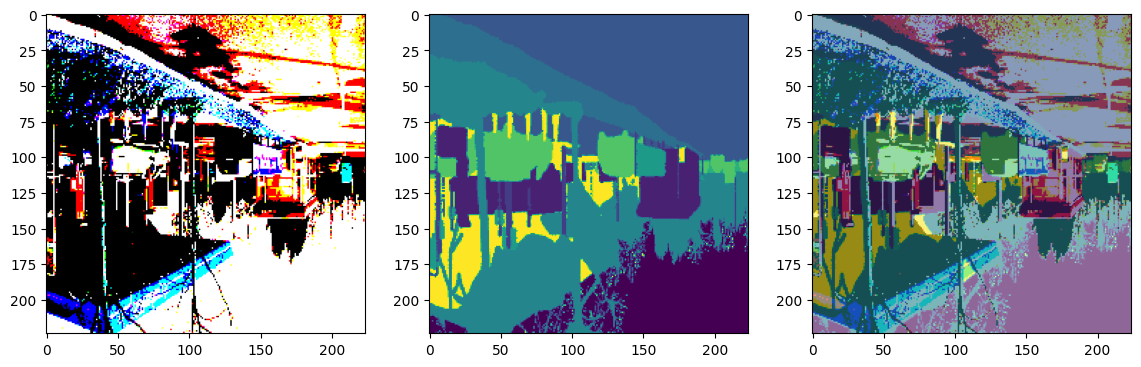

In [50]:
for images,masks in train_dataset:
    figure = plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.imshow(images[0])
    plt.subplot(132)
    plt.imshow(masks[0])
    plt.subplot(133)
    plt.imshow(images[0])
    plt.imshow(masks[0],alpha=0.6)
    plt.show();
    break

In [21]:
print_once = True
batches=0
imgs = 0
msks = 0
for images, masks in train_dataset:
    if print_once == True:
        print(f'Each Image Batch Dimensions: ---> {images.shape}')
        print(f'Each Mask Batch Dimensions:  ---> {masks.shape}')
        print('\n')
        print_once=False
    batches +=1
    for image in images:
        imgs+=1
    for mask in masks:
        msks+=1
print('------TRAINING DATASET------')
print(f'Total Batches: ---> {batches}')
print(f'Total Images:  ---> {imgs}')
print(f'Total Masks:   ---> {msks}')

Each Image Batch Dimensions: ---> (8, 224, 224, 3)
Each Mask Batch Dimensions:  ---> (8, 224, 224, 1)


------TRAINING DATASET------
Total Batches: ---> 221
Total Images:  ---> 1761
Total Masks:   ---> 1761


In [20]:
val_dataset = tf_dataset(img_filepaths, msk_filepaths, batch=8, split='val')

In [21]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

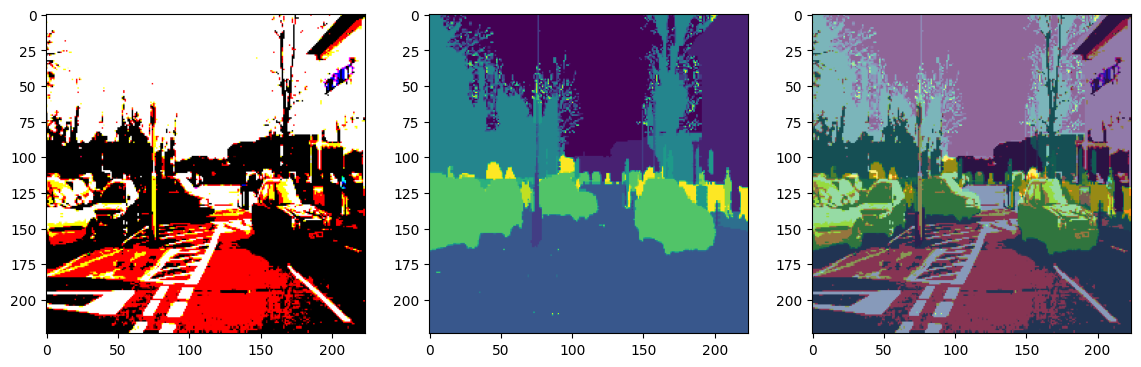

In [48]:
for images,masks in val_dataset:
    figure = plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.imshow(images[0])
    plt.subplot(132)
    plt.imshow(masks[0])
    plt.subplot(133)
    plt.imshow(images[0])
    plt.imshow(masks[0],alpha=0.6)
    plt.show();
    break

In [25]:
print_once = True
batches=0
imgs = 0
msks = 0
for images, masks in val_dataset:
    if print_once == True:
        print(f'Each Image Batch Dimensions: ---> {images.shape}')
        print(f'Each Mask Batch Dimensions:  ---> {masks.shape}')
        print('\n')
        print_once=False
    batches +=1
    for image in images:
        imgs+=1
    for mask in masks:
        msks+=1
print('------VALIDATION DATASET------')
print(f'Total Batches: ---> {batches}')
print(f'Total Images:  ---> {imgs}')
print(f'Total Masks:   ---> {msks}')

Each Image Batch Dimensions: ---> (8, 224, 224, 3)
Each Mask Batch Dimensions:  ---> (8, 224, 224, 1)


------VALIDATION DATASET------
Total Batches: ---> 56
Total Images:  ---> 441
Total Masks:   ---> 441


In [22]:
test_dataset = tf_dataset(test_img_filepaths, test_msk_filepaths, batch=8, split='test')

In [23]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

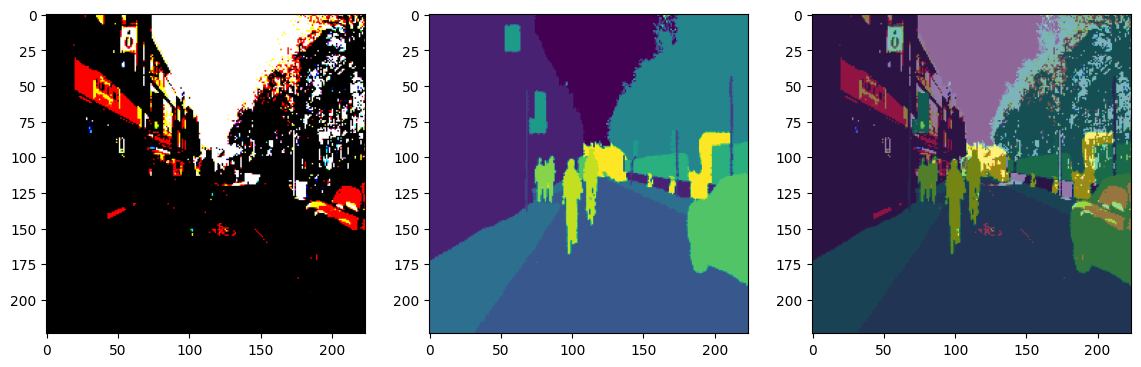

In [28]:
for images,masks in test_dataset:
    figure = plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.imshow(images[0])
    plt.subplot(132)
    plt.imshow(masks[0])
    plt.subplot(133)
    plt.imshow(images[0])
    plt.imshow(masks[0],alpha=0.6)
    plt.show();
    break

In [29]:
print_once = True
batches=0
imgs = 0
msks = 0
for images, masks in test_dataset:
    if print_once == True:
        print(f'Each Image Batch Dimensions: ---> {images.shape}')
        print(f'Each Mask Batch Dimensions:  ---> {masks.shape}')
        print('\n')
        print_once=False
    batches +=1
    for image in images:
        imgs+=1
    for mask in masks:
        msks+=1
print('------TESTING DATASET------')
print(f'Total Batches: ---> {batches}')
print(f'Total Images:  ---> {imgs}')
print(f'Total Masks:   ---> {msks}')

Each Image Batch Dimensions: ---> (8, 224, 224, 3)
Each Mask Batch Dimensions:  ---> (8, 224, 224, 1)


------TESTING DATASET------
Total Batches: ---> 13
Total Images:  ---> 101
Total Masks:   ---> 101


# First Model

In [24]:
first_model = sm.Unet(backbone_name='vgg16', encoder_weights='imagenet', classes=12, activation='softmax')

58889256/58889256 [==============================] - 1s 0us/step


In [25]:
def custom_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=12)
    
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return loss

In [26]:
def mean_iou(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=12)
    
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_pred = tf.one_hot(y_pred, depth=12)
    
    y_true_flatten = tf.keras.backend.flatten(y_true)
#     print(y_true_flatten.shape)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
#     print(y_pred_flatten.shape)

    
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    union = (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten)) - intersection
    
    final_val = intersection / union
    
    return final_val

In [27]:
tf.keras.backend.clear_session()

In [28]:
num_epochs = 10

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []


for epoch in range(num_epochs):
    
    first_model.compile(optimizer='adam',
                 loss = custom_loss,
                 metrics = ['accuracy', mean_iou])
    
    hist = first_model.fit(train_dataset,
             epochs=1,
             verbose=1,
             validation_data = val_dataset)
    
    train_loss.append(hist.history['loss'][0])
    train_accuracy.append(hist.history['accuracy'][0])
    val_loss.append(hist.history['val_loss'][0])
    val_accuracy.append(hist.history['val_accuracy'][0])
    
    tf.keras.backend.clear_session()


221/221 [==============================] - 46s 140ms/step - loss: 0.3817 - accuracy: 0.8885 - mean_iou: 0.8003 - val_loss: 0.3625 - val_accuracy: 0.8952 - val_mean_iou: 0.8102


In [29]:
tf.keras.backend.clear_session()

# Training Graphs

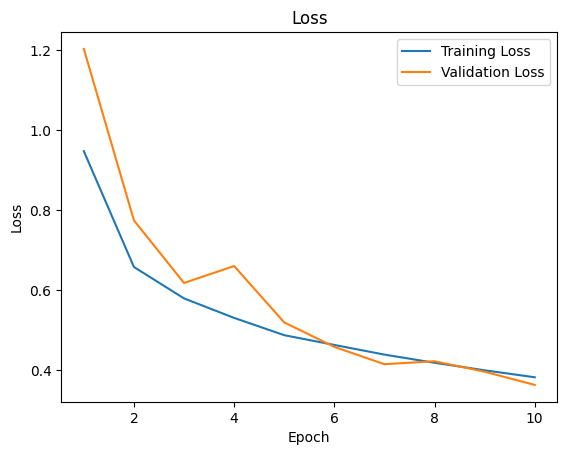

In [30]:

plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



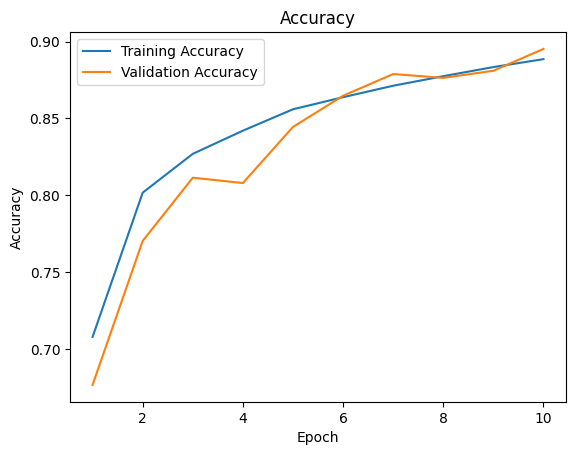

In [31]:
plt.plot(range(1, num_epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Quantitative Performance Measures

In [32]:
test_images = test_dataset.map(lambda x,y: x)
test_masks = test_dataset.map(lambda x,y: y).unbatch()
test_masks = list(test_masks)

In [33]:
preds = first_model.predict(test_images,
                     verbose=1)
pred = tf.split(preds, preds.shape[0], axis=0)
test_preds = [tf.squeeze(x, axis=0) for x in pred]

13/13 [==============================] - 2s 97ms/step


In [37]:
def Dice(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=12)
    
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_pred = tf.one_hot(y_pred, depth=12)
    
    diceloss = sm.losses.DiceLoss()
    loss_val = diceloss(y_true, y_pred)
    
    return loss_val

In [38]:
def F1score(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=12)
    
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_pred = tf.one_hot(y_pred, depth=12)
    
    f1score = sm.metrics.FScore()
    f1_val = f1score(y_true, y_pred)
    
    return f1_val

In [39]:
acc = first_model.evaluate(test_dataset)

13/13 [==============================] - 2s 37ms/step - loss: 0.4427 - accuracy: 0.8719 - mean_iou: 0.7737


In [41]:
print('----------------QUALITATIVE MEASURES-----------------')
print('\n')
print(f'Dice Score:       ----->    {Dice(test_masks,test_preds)}')
print(f'F1 Score:         ----->    {F1score(test_masks,test_preds)}')
print(f'MeanIoU Score:    ----->    {mean_iou(test_masks,test_preds)}')
print(f'Accuracy Score:   ----->    {acc[1]}')

----------------QUALITATIVE MEASURES-----------------


Dice Score:       ----->    0.6313637495040894
F1 Score:         ----->    0.36863625049591064
MeanIoU Score:    ----->    0.5425319671630859
Accuracy Score:   ----->    0.8719215393066406


Image Index: 44
/kaggle/working/A3_Dataset/dataset1/images_prepped_test/0016E5_08047.png
1/1 [==============================] - 0s 22ms/step


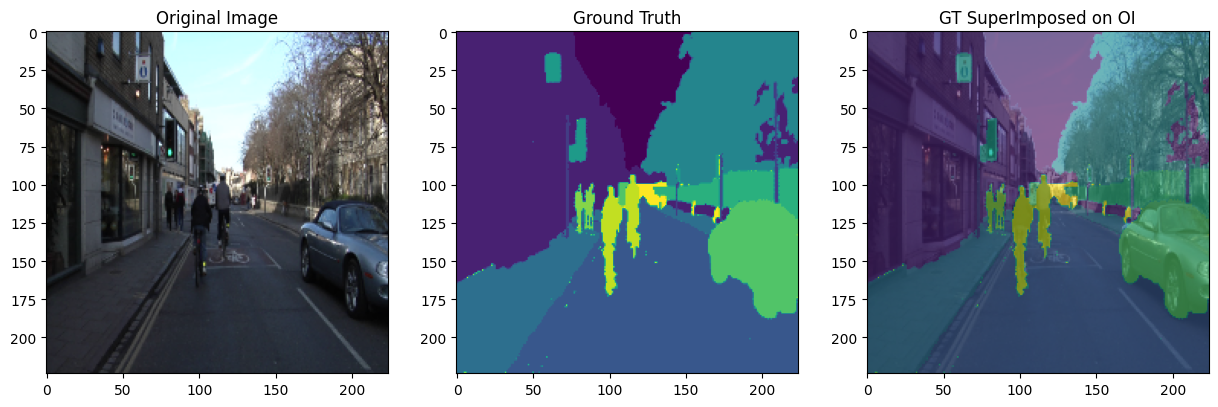

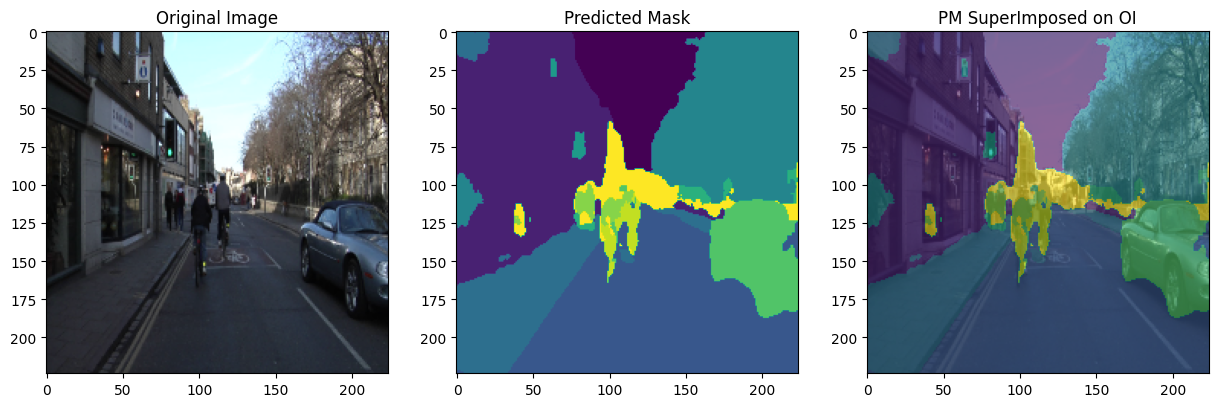

In [47]:
import random
img = random.randint(0, len(test_img_filepaths)-1)
print(f'Image Index: {img}')
print(test_img_filepaths[img])
tsv = cv2.imread(test_img_filepaths[img])
tsv = cv2.cvtColor(tsv, cv2.COLOR_BGR2RGB)
tsv = cv2.resize(tsv, (224,224))

mask = cv2.imread(test_msk_filepaths[img],0)
mask = cv2.resize(mask,(224,224))

processed_image = preprocessor(tsv)
new_img = tf.expand_dims(processed_image, axis=0)


pred_mask = first_model.predict(new_img)
pred_mask=tf.squeeze(pred_mask,axis=0)
pred_mask = tf.argmax(pred_mask, axis=-1)

fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(tsv)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(mask)
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(tsv)
plt.imshow(mask, alpha=0.6)
plt.title('GT SuperImposed on OI')
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(tsv)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(pred_mask)
plt.title('Predicted Mask')
plt.subplot(133)
plt.imshow(tsv)
plt.imshow(pred_mask, alpha=0.6)
plt.title('PM SuperImposed on OI')
plt.show();